<a href="https://colab.research.google.com/github/Meta-Sean/Practical-Deep-Learning/blob/main/space_titanic_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space Titanic
- Predict which passengers are transported to an alternate dimension

# File and Data Field Descriptions
- train.csv - Personal records for about two-thirds (~8700) of the    passengers, to be used as training data.
  - PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
  - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
  - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
  - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
  - Destination - The planet the passenger will be debarking to.
  - Age - The age of the passenger.
  - VIP - Whether the passenger has paid for special VIP service during the voyage.
  - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
  - Name - The first and last names of the passenger.
  - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
- test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
  - PassengerId - Id for each passenger in the test set.
  - Transported - The target. For each passenger, predict either True or False.



In [9]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from google.colab import files
import pandas as pd
uploaded = files.upload()

Saving kaggle.json to kaggle (4).json


In [11]:
! mkdir ~/.kaggle #creating folder
! cp kaggle.json ~/.kaggle/ #copying kaggle.json
! chmod 600 ~/.kaggle/kaggle.json #reading the file with full access

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/spaceship-titanic')
    !pip install -Uqq fastai
else:
    import pandas as pd
    import zipfile,kaggle
    path = Path('spaceship-titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
df = pd.read_csv('spaceship-titanic/train.csv')
tst_df = pd.read_csv('spaceship-titanic/test.csv')
modes = df.mode().iloc[0]
df['Transported'] = df['Transported'].apply(lambda x: 1 if x == True else 0)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
dtypes: float64(6), int64(1), object(7)
memory usage: 950.9+ KB


In [15]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

## Data preprocessing

In [16]:
import numpy as np

def add_features(df):
  df.fillna(modes, inplace=True)
  df['LogRoomService'] = np.log(df['RoomService']+1)
  df['LogFoodCourt'] = np.log(df['FoodCourt']+1)
  df['LogShoppingMall'] = np.log(df['ShoppingMall']+1)
  df['LogSpa'] = np.log(df['Spa']+1)
  df['LogVRDeck'] = np.log(df['VRDeck']+1)
  df[['Deck','CabinNumber','Side']] = df.Cabin.str.split('/', expand=True)
  df[['Group', 'PassengerNumber']] = df.PassengerId.str.split('_', expand=True)

add_features(df)
add_features(tst_df)

In [17]:
def proc_data(df):
  df.fillna(modes, inplace=True)
  df['HomePlanet'] = pd.Categorical(df.HomePlanet)
  df["CryoSleep"] = pd.Categorical(df.CryoSleep)
  df['Destination'] = pd.Categorical(df.Destination)
  df['Deck'] = pd.Categorical(df.Deck)
  df['CabinNumber'] = pd.Categorical(df.HomePlanet)
  df['Side'] = pd.Categorical(df.Side)
  df['Group'] = pd.Categorical(df.Group)
  df['PassengerNumber'] = pd.Categorical(df.PassengerNumber)
  

proc_data(df)
proc_data(tst_df)


In [18]:
cats=["HomePlanet", "CryoSleep", "Destination", "Deck", "CabinNumber", "Side", "Group", "PassengerNumber"]
conts=['Age', 'LogRoomService', 'LogFoodCourt', 'LogShoppingMall', 'LogSpa', 'LogVRDeck']
dep="Transported"

In [19]:
# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
df.CryoSleep.head()

In [65]:
df.CryoSleep.cat.codes.head()

0    0
1    0
2    0
3    0
4    0
dtype: int8

## Binary splits

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fix,axs = plt.subplots(1, 2, figsize=(11, 5))
sns.barplot(data=df, y=dep, x="CryoSleep", ax=axs[0]).set(title="Transportation rate")
sns.countplot(data=df, x='CryoSleep', ax=axs[1]).set(title='Histogram')

In [ ]:
 from numpy import random
 from sklearn.model_selection import train_test_split
 
 random.seed(42)
 trn_df, val_df = train_test_split(df, test_size=0.25)
 trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
 val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [ ]:
def xs_y(df):
  xs = df[cats+conts].copy()
  return xs, df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

In [ ]:
trn_xs.info()

In [ ]:
preds = val_xs.CryoSleep==1
val_y

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

In [ ]:
df_age = trn_df[trn_df.Age>0]
fig, axs = plt.subplots(1,2, figsize=(11, 5))
sns.boxenplot(data=df_age, x=dep, y="Age", ax=axs[0])
sns.kdeplot(data=df_age, x="Age", ax=axs[1]);

## Not really conclusive quantiles for age and transportation
Lets write a score function to try out a few different splits

In [ ]:
def _side_score(side, y):
  tot = side.sum()
  if tot<=1: return 0
  return y[side].std()*tot

In [ ]:
def score(col, y, split):
  lhs = col<=split
  return (_side_score(lhs, y) + _side_score(~lhs, y))/len(y)

In [ ]:
score(trn_xs["CryoSleep"], trn_y, 0.5)

In [ ]:
score(trn_xs['Age'], trn_y, 20)

In [ ]:
def iscore(nm, split):
  col = trn_xs[nm]
  return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

In [ ]:
interact(nm=cats, split=2)(iscore);

## Instead of manually doing this lets write a function that can automatically find the best split point for all our columns

In [ ]:
def min_col(df, nm):
  col, y = df[nm], df[dep]
  unq = col.dropna().unique()
  scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
  idx = scores.argmin()
  return unq[idx], scores[idx]

min_col(trn_df, "Age")

In [ ]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

# Decision Tree!!!

In [ ]:
trn_df.isnull().sum()

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [ ]:
import graphviz
import re

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

In [ ]:
draw_tree(m, trn_xs, size=10)

In [ ]:
def gini(cond):
  act = df.loc[cond, dep]
  return 1 - act.mean()**2 - (1-act).mean()**2

In [ ]:
gini(df.CryoSleep==0), gini(df.CryoSleep==1)

In [ ]:
mean_absolute_error(val_y, m.predict(val_xs))

In [ ]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=25)

In [ ]:
mean_absolute_error(val_y, m.predict(val_xs))

In [ ]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
  tst_df['Transported'] = list(map(lambda x: True if x == 1 else False, preds))
  sub_df = tst_df[['PassengerId', 'Transported']]
  sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

In [ ]:
#! kaggle competitions submit -c spaceship-titanic -f sub-tree.csv -m 'decision tree'

# Random Forest

In [ ]:
def get_tree(prop=0.75):
  n = len(trn_y)
  idxs = random.choice(n, int(n*prop))
  return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [ ]:
trees = [get_tree() for t in range(100)]

In [ ]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y)
mean_absolute_error(val_y, rf.predict(val_xs))

In [ ]:
subm(rf.predict(tst_xs), 'rf')

In [ ]:
#! kaggle competitions submit -c spaceship-titanic -f sub-rf.csv -m 'random forest'

In [ ]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh')

In [ ]:
from sklearn.model_selection import cross_val_score

## XG Boost

In [67]:
import xgboost as xgb
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.001,
                max_depth = 8, alpha = 1, n_estimators = 400)

scores = cross_val_score(xg_reg, trn_xs, trn_y, cv=5)
scores.mean()

0.801351176379191

In [66]:
xg_reg.fit(trn_xs, trn_y)
subm(xg_reg.predict(tst_xs), 'xgb')

In [74]:
! kaggle competitions submit -c spaceship-titanic -f sub-xgb.csv -m 'xbg'

100% 56.5k/56.5k [00:00<00:00, 282kB/s]
Successfully submitted to Spaceship Titanic

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(random_state=0,max_iter=500)
scores = cross_val_score(clf, trn_xs, trn_y, cv=5)
scores.mean()

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(14,)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(24, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) 

In [69]:
model.fit(trn_xs, trn_y, epochs=500, batch_size=10, validation_split=0.25)

Epoch 1/500
489/489 [==============================] - 3s 5ms/step - loss: 0.6221 - accuracy: 0.7269 - val_loss: 0.5624 - val_accuracy: 0.7589
Epoch 2/500
489/489 [==============================] - 2s 4ms/step - loss: 0.6466 - accuracy: 0.7132 - val_loss: 0.5689 - val_accuracy: 0.7393
Epoch 3/500
489/489 [==============================] - 2s 3ms/step - loss: 0.5985 - accuracy: 0.7359 - val_loss: 0.7334 - val_accuracy: 0.6644
Epoch 4/500
489/489 [==============================] - 2s 4ms/step - loss: 0.6036 - accuracy: 0.7308 - val_loss: 0.4989 - val_accuracy: 0.7773
Epoch 5/500
489/489 [==============================] - 2s 3ms/step - loss: 0.5875 - accuracy: 0.7368 - val_loss: 0.4838 - val_accuracy: 0.7804
Epoch 6/500
489/489 [==============================] - 2s 3ms/step - loss: 0.6023 - accuracy: 0.7249 - val_loss: 0.4985 - val_accuracy: 0.7724
Epoch 7/500
489/489 [==============================] - 2s 3ms/step - loss: 0.5893 - accuracy: 0.7357 - val_loss: 0.4804 - val_accuracy: 0.7847

In [ ]:
trn_xs.shape

In [70]:
model.fit(trn_xs, trn_y)

204/204 [==============================] - 1s 7ms/step - loss: 0.5325 - accuracy: 0.7871


In [71]:
subm(model.predict(tst_xs), 'NN')

In [73]:
!kaggle competitions submit -c spaceship-titanic -f sub-NN.csv -m 'NN'

100% 58.3k/58.3k [00:00<00:00, 276kB/s]
Successfully submitted to Spaceship Titanic

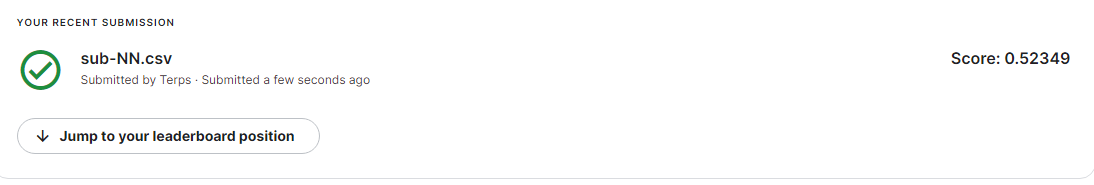